# Information Extraction

In [1]:
# Load Libraries
import pandas as pd
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tree import Tree
import spacy
import re
from joblib import Parallel, delayed
from itertools import combinations 
import numpy as np

## Format Data

In [2]:
df = pd.read_csv("filter_50krows.csv")
# df.info()

# Keep only relevant columns
df = df[['From', 'To', 'Content']]

# Convert emails to lowercase for uniformity
df['Content'] = df['Content'].str.lower()
df['To'] = df['To'].str.lower()
df['From'] = df['From'].str.lower()

# Ensure columns are treated as strings
df['To'] = df['To'].astype(str)
df['From'] = df['From'].astype(str)
df['Content'] = df['Content'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   From     50000 non-null  object
 1   To       50000 non-null  object
 2   Content  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


## Extract Sender & Recipient Names Using Regex

In [3]:
# Function to extract and clean names from email addresses
def extract_names(email):
    if pd.isna(email):
        return None
    # Extract the username part of the email
    matches = re.findall(r'([\w\.-]+)@[\w\.-]+', email)
    if matches:
        # Replace non-alphabetic characters (except spaces) with a space
        cleaned_names = [re.sub(r'[^a-zA-Z]', ' ', name).strip() for name in matches]
        return ', '.join(cleaned_names)
    return None

# Apply the function to both columns, handling multiple emails in a row
df['From_Names'] = df['From'].str.split(',').apply(lambda x: [extract_names(email.strip()) for email in x])
df['To_Names'] = df['To'].str.split(',').apply(lambda x: [extract_names(email.strip()) for email in x])

# Convert lists to comma-separated strings for readability
df['From_Names'] = df['From_Names'].apply(lambda x: ', '.join(filter(None, x)))
df['To_Names'] = df['To_Names'].apply(lambda x: ', '.join(filter(None, x)))

# Display a sample output
df.head(20)

,From,To,Content,From_Names,To_Names
0,phillip.allen@enron.com,john.lavorato@enron.com,traveling to have a business meeting takes the...,phillip allen,john lavorato
1,phillip.allen@enron.com,randall.gay@enron.com,"randy,\n\n can you send me a schedule of the s...",phillip allen,randall gay
2,phillip.allen@enron.com,"david.l.johnson@enron.com, john.shafer@enron.com",please cc the following distribution list with...,phillip allen,"david l johnson, john shafer"
3,phillip.allen@enron.com,mark.scott@enron.com,1. login: pallen pw: ke9davis\n\n i don't thi...,phillip allen,mark scott
4,phillip.allen@enron.com,zimam@enron.com,---------------------- forwarded by phillip k ...,phillip allen,zimam
5,phillip.allen@enron.com,buck.buckner@honeywell.com,"mr. buckner,\n\n for delivered gas behind san ...",phillip allen,buck buckner
6,phillip.allen@enron.com,stagecoachmama@hotmail.com,"lucy,\n\n here are the rentrolls:\n\n\n\n open...",phillip allen,stagecoachmama
7,phillip.allen@enron.com,keith.holst@enron.com,---------------------- forwarded by phillip k ...,phillip allen,keith holst
8,phillip.allen@enron.com,keith.holst@enron.com,---------------------- forwarded by phillip k ...,phillip allen,keith holst
9,phillip.allen@enron.com,david.delainey@enron.com,"dave, \n\n here are the names of the west desk...",phillip allen,david delainey


## NER

### NER Function

In [ ]:
## WORKS - but NER could be improved
# # Load spaCy's English model
# nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

# def extract_named_entities_spacy(texts, batch_size=600):
#     """
#     Extracts PERSON named entities from a list of texts using spaCy.
    
#     Args:
#         texts (list or Pandas Series): The text data to process.
#         batch_size (int): The number of documents to process in a batch for efficiency.
    
#     Returns:
#         list: A list of extracted PERSON entities for each text.
#     """
#     named_entities = []
    
#     # Process texts in batches for efficiency
#     for doc in nlp.pipe(texts, batch_size=batch_size, n_process=-1):  # Use all CPU cores
#         persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
#         named_entities.append(", ".join(persons))  # Join names into a single string
    
#     return named_entities




# Load spaCy's English model with only NER for efficiency
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

# Content column oftne contains emails, so we may need to extract the person entities from the email addresses
# Function to extract and clean names from email addresses
def extract_names(email):
    if pd.isna(email):
        return None
    # Extract the username part of the email
    matches = re.findall(r'([\w\.-]+)@[\w\.-]+', email)
    if matches:
        # Replace non-alphabetic characters (except spaces) with a space
        cleaned_names = [re.sub(r'[^a-zA-Z]', ' ', name).strip() for name in matches]
        return ', '.join(cleaned_names)
    return None

def extract_named_entities_spacy(texts, batch_size=600):
    """Extract PERSON named entities and email names, ensuring proper separation of names and uniqueness."""
    named_entities = []
    
    for doc in nlp.pipe(texts, batch_size=batch_size, n_process=-1):
        persons = set()  # Use a set to ensure uniqueness
        
        # Extract names from email addresses in the text
        email_names = extract_names(doc.text)
        if email_names:
            for name in email_names.split(', '):
                persons.add(name.strip())
        
        # Extract PERSON named entities
        for ent in doc.ents:
            if ent.label_ == "PERSON":
                cleaned_name = ent.text
                
                # Replace newline & slash with space to avoid merging words
                cleaned_name = re.sub(r'[\n/]', ' ', cleaned_name)
                
                # Remove possessive ('s) without merging words
                cleaned_name = re.sub(r"\b(\w+)'s\b", r'\1', cleaned_name)
                
                # Remove non-alphabetic characters while keeping spaces
                cleaned_name = re.sub(r'[^a-zA-Z ]+', '', cleaned_name).strip()
                
                # Ensure multi-word names remain intact
                if cleaned_name:
                    persons.add(cleaned_name)
        
        # Join names properly and ensure no duplicates
        named_entities.append(", ".join(persons))  # Join names properly
    
    return named_entities

### Run NER on Content

In [ ]:
# Do not run the function on the entire Content column, likely will crash
df.loc[:999, 'named_entities_content'] = pd.Series(extract_named_entities_spacy(df['Content'].iloc[:1000], batch_size=600)).values # Approx <1min

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(20)
# print(df.iloc[980:1001].to_markdown())

From                                                To  \
0   phillip.allen@enron.com                           john.lavorato@enron.com   
1   phillip.allen@enron.com                             randall.gay@enron.com   
2   phillip.allen@enron.com  david.l.johnson@enron.com, john.shafer@enron.com   
3   phillip.allen@enron.com                              mark.scott@enron.com   
4   phillip.allen@enron.com                                   zimam@enron.com   
5   phillip.allen@enron.com                        buck.buckner@honeywell.com   
6   phillip.allen@enron.com                        stagecoachmama@hotmail.com   
7   phillip.allen@enron.com                             keith.holst@enron.com   
8   phillip.allen@enron.com                             keith.holst@enron.com   
9   phillip.allen@enron.com                          david.delainey@enron.com   
10  phillip.allen@enron.com                              ina.rangel@enron.com   
11  phillip.allen@enron.com                         tim.heizenrader@enron.com   
12  phillip.allen@enron.com                              pallen70@hotmail.com   
13  phillip.allen@enron.com                              ina.rangel@enron.com   
14  phillip.allen@enron.com                                bs_stone@yahoo.com   
15  phillip.allen@enron.com                         stouchstone@natsource.com   
16  phillip.allen@enron.com                                bs_stone@yahoo.com   
17  phillip.allen@enron.com                                      lkuch@mh.com   
18  phillip.allen@enron.com                           jeffrey.hodge@enron.com   
19  phillip.allen@enron.com                                  kholst@enron.com   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

#### From NER results on Content column, there are several errors that need to be rectified:

- Remove enronenron name, OR trim names that end with enronenron OR corp enronenron
- Remove ect name, or trim names that end with ect
- Trim names that end with "hou"
- There are multiple instances of the same name in different formats (e.g. phillip k allen = phillip allen = pallen, kristin walsh = kristin)

## Dependency Parsing in Content

In [4]:
# Optimised dependency parsing
# Load spaCy's English model for dependency parsing.
# Disable components that are not need for this task (NER, lemmatizer, tagger) to save time
nlp_dep = spacy.load("en_core_web_sm", disable=["ner", "lemmatizer", "tagger"])

def dependency_parse(text):
    """
    Processes a single text string through the dependency parser.
    Returns a list of tuples: (token.text, token.dep_, token.head.text):
      - token.text is the actual word,
      - token.dep_ is the dependency relation label,
      - token.head.text is the text of the head token (the word this token depends on).
    """
    doc = nlp_dep(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

def get_dependency_parses(texts, batch_size=500):
    """
    Processes a list of texts using spaCy's nlp.pipe() for batch processing.
    Uses multiprocessing (n_process=-1) to parallelize the work on all available CPU cores.
    Returns a list where each element is the dependency parse result (list of tuples) for a text.
    """
    results = []
    for doc in nlp_dep.pipe(texts, batch_size=batch_size, n_process=-1):
        # For each document, extract the dependency tuples.
        results.append([(token.text, token.dep_, token.head.text) for token in doc])
    return results

# Select only the first 2000 rows
df_subset = df.head(2000)

# Perform dependency parsing on the "Content" column of the first 2000 rows
dependency_results = get_dependency_parses(df_subset["Content"].tolist(), batch_size=500)
df_subset["dependency_parse"] = dependency_results

# subset of 2000 rows -> 58 seconds runtime

/var/folders/99/hyw7fyz52lz7m604zpx79qhr0000gn/T/ipykernel_1678/2553444110.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["dependency_parse"] = dependency_results


In [ ]:
pd.set_option('display.max_colwidth', None)
df_subset.tail(10)

,From,To,Content,From_Names,To_Names,dependency_parse
1990,phillip.allen@enron.com,laird.dyer@enron.com,"laird,\n\n did you meet with swg on april 27th. are there any other asset management \ntargets in the west?\n\n\n---------------------- forwarded by phillip k allen/hou/ect on 04/27/2000 \n01:53 pm ---------------------------\n\n\njane m tholt\n04/12/2000 08:45 am\nto: phillip k allen/hou/ect@ect\ncc: \nsubject: sw gas\n\n\n---------------------- forwarded by jane m tholt/hou/ect on 04/12/2000 10:45 \nam ---------------------------\n\n\nlaird dyer\n04/12/2000 08:17 am\nto: jane m tholt/hou/ect@ect\ncc: \nsubject: sw gas\n\njanie,\n\nthanks for the fax on sw gas.\n\nwe are meeting with larry black, bob armstrong & ed zub on april 27th to \ndiscuss asset management. in preparation for that meeting we would like to \ngain an understanding of the nature of our business relationship with sw. \ncould you, in general terms, describe our sales activities with sw. what are \ntypical quantities and term on sales? are there any services we provide? \nhow much pipeline capacity do we buy or sell to them? who are your main \ncontacts at sw gas?\n\nwe will propose to provide a full requirements supply to sw involving our \ncontrol of their assets. for this to be attractive to sw, we will probably \nhave to take on their regulatory risk on gas purchase disallowance with the \ncommissions. this will be difficult as there is no clear mandate from their \ncommissions as to what an acceptable portfolio (fixed, indexed, collars....) \nshould look like. offering them a guaranteed discount to the 1st of month \nindex may not be attractive unless we accept their regulatory risk. that \nrisk may not be acceptable to the desk. i will do some investigation of \ntheir pga's and see if there is an opportunity.\n\nas to the asset management: do you have any preference on structure? are \nthere elements that you would like to see? any ideas at all would be greatly \nappreciated.\n\nthanks,\n\nlaird",phillip allen,laird dyer,"[(laird, advmod, meet), (,, punct, meet), (\n\n , dep, ,), (did, aux, meet), (you, nsubj, meet), (meet, ROOT, meet), (with, prep, meet), (swg, pobj, with), (on, prep, meet), (april, compound, 27th), (27th, pobj, on), (., punct, meet), ( , dep, .), (are, ROOT, are), (there, expl, are), (any, det, targets), (other, amod, targets), (asset, compound, management), (management, compound, targets), (\n, dep, management), (targets, attr, are), (in, prep, targets), (the, det, west), (west, pobj, in), (?, punct, are), (\n\n\n, dep, ?), (----------------------, punct, phillip), (forwarded, acl, ----------------------), (by, agent, forwarded), (phillip, compound, hou), (k, nmod, hou), (allen, nmod, hou), (/, punct, hou), (hou, compound, ect), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/27/2000, nummod, pm), (\n, dep, 04/27/2000), (01:53, nummod, pm), (pm, pobj, on), (---------------------------, punct, pm), (\n\n\n, dep, ---------------------------), (jane, appos, pm), (m, nsubj, phillip), (tholt, attr, m), (\n, dep, tholt), (04/12/2000, nummod, tholt), (08:45, attr, m), (am, nsubj, m), (\n, dep, am), (to, prep, m), (:, punct, to), (phillip, ROOT, phillip), (k, nmod, ect@ect), (allen, nmod, ect@ect), (/, punct, ect@ect), (hou, nmod, ect@ect), (/, punct, ect@ect), (ect@ect, acomp, phillip), (\n, dep, ect@ect), (cc, nsubj, phillip), (:, punct, subject), ( \n, dep, :), (subject, appos, phillip), (:, punct, subject), (sw, compound, gas), (gas, appos, subject), (\n\n\n, dep, gas), (----------------------, punct, subject), (forwarded, acl, subject), (by, agent, forwarded), (jane, compound, ect), (m, compound, ect), (tholt, nmod, hou), (/, punct, hou), (hou, nsubj, m), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/12/2000, nsubj, am), (10:45, nummod, 04/12/2000), (\n, dep, 10:45), (am, ccomp, phillip), (---------------------------, punct, am), (\n\n\n, dep, ---------------------------), (laird, compound, dyer), (dyer, c

### Extract SVO Relationships from Dependency Parsing Results

In [6]:
# Extract Subject-Verb-Object (SVO) relationships
def extract_svo_from_dependency(dependency_parse):
    """
    Extracts Subject-Verb-Object (SVO) relationships from dependency parsing results.
    :param dependency_parse: List of (token, dependency relation, head token)
    :return: List of (subject, verb, object) tuples
    """
    subjects = {}
    objects = {}
    verbs = {}

    # Process the tokens and their dependency relations
    for token, dep, head in dependency_parse:
        if dep in ("nsubj", "nsubjpass"):  # Subject detection
            subjects[head] = token
        elif dep in ("dobj", "pobj"):  # Object detection
            objects[head] = token
        elif dep in ("ROOT", "auxpass"):  # Verbs (main verbs in ROOT)
            verbs[token] = token

    # Form SVO triplets directly from the available subject, verb, and object mappings
    return [(subjects[verb], verb, objects[verb]) for verb in verbs if verb in subjects and verb in objects]

# Parallel processing of the SVO extraction
def process_svo_batch(batch):
    """
    Processes a batch of rows for SVO extraction using parallelized function
    """
    return [extract_svo_from_dependency(row) for row in batch]

def run_parallel_svo_extraction(df, num_cores=-1):
    """
    Runs SVO extraction in parallel for efficiency.
    :param df: DataFrame containing the 'dependency_parse' column
    :param num_cores: Number of cores to use for parallel processing (-1 for all available cores)
    :return: DataFrame with added 'SVO_Relationships' column
    """
    # Split the DataFrame into smaller batches for parallel processing
    batch_size = 100  
    batches = [df["dependency_parse"][i:i + batch_size] for i in range(0, len(df), batch_size)]

    # Run the batch processing in parallel
    results = Parallel(n_jobs=num_cores)(delayed(process_svo_batch)(batch) for batch in batches)

    # Flatten the results from the batches and assign to the DataFrame
    df["SVO_Relationships"] = [item for sublist in results for item in sublist]
    return df

# Sample DataFrame processing
df_subset = run_parallel_svo_extraction(df_subset)

# Display the results
pd.set_option('display.max_colwidth', None)
df_subset.tail(10)

#if this code takes too long to run, try uncommenting the code above and run that instead (both code blocks will give the same output)

/var/folders/99/hyw7fyz52lz7m604zpx79qhr0000gn/T/ipykernel_1678/3660682952.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SVO_Relationships"] = [item for sublist in results for item in sublist]


,From,To,Content,From_Names,To_Names,dependency_parse,SVO_Relationships
1990,phillip.allen@enron.com,laird.dyer@enron.com,"laird,\n\n did you meet with swg on april 27th. are there any other asset management \ntargets in the west?\n\n\n---------------------- forwarded by phillip k allen/hou/ect on 04/27/2000 \n01:53 pm ---------------------------\n\n\njane m tholt\n04/12/2000 08:45 am\nto: phillip k allen/hou/ect@ect\ncc: \nsubject: sw gas\n\n\n---------------------- forwarded by jane m tholt/hou/ect on 04/12/2000 10:45 \nam ---------------------------\n\n\nlaird dyer\n04/12/2000 08:17 am\nto: jane m tholt/hou/ect@ect\ncc: \nsubject: sw gas\n\njanie,\n\nthanks for the fax on sw gas.\n\nwe are meeting with larry black, bob armstrong & ed zub on april 27th to \ndiscuss asset management. in preparation for that meeting we would like to \ngain an understanding of the nature of our business relationship with sw. \ncould you, in general terms, describe our sales activities with sw. what are \ntypical quantities and term on sales? are there any services we provide? \nhow much pipeline capacity do we buy or sell to them? who are your main \ncontacts at sw gas?\n\nwe will propose to provide a full requirements supply to sw involving our \ncontrol of their assets. for this to be attractive to sw, we will probably \nhave to take on their regulatory risk on gas purchase disallowance with the \ncommissions. this will be difficult as there is no clear mandate from their \ncommissions as to what an acceptable portfolio (fixed, indexed, collars....) \nshould look like. offering them a guaranteed discount to the 1st of month \nindex may not be attractive unless we accept their regulatory risk. that \nrisk may not be acceptable to the desk. i will do some investigation of \ntheir pga's and see if there is an opportunity.\n\nas to the asset management: do you have any preference on structure? are \nthere elements that you would like to see? any ideas at all would be greatly \nappreciated.\n\nthanks,\n\nlaird",phillip allen,laird dyer,"[(laird, advmod, meet), (,, punct, meet), (\n\n , dep, ,), (did, aux, meet), (you, nsubj, meet), (meet, ROOT, meet), (with, prep, meet), (swg, pobj, with), (on, prep, meet), (april, compound, 27th), (27th, pobj, on), (., punct, meet), ( , dep, .), (are, ROOT, are), (there, expl, are), (any, det, targets), (other, amod, targets), (asset, compound, management), (management, compound, targets), (\n, dep, management), (targets, attr, are), (in, prep, targets), (the, det, west), (west, pobj, in), (?, punct, are), (\n\n\n, dep, ?), (----------------------, punct, phillip), (forwarded, acl, ----------------------), (by, agent, forwarded), (phillip, compound, hou), (k, nmod, hou), (allen, nmod, hou), (/, punct, hou), (hou, compound, ect), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/27/2000, nummod, pm), (\n, dep, 04/27/2000), (01:53, nummod, pm), (pm, pobj, on), (---------------------------, punct, pm), (\n\n\n, dep, ---------------------------), (jane, appos, pm), (m, nsubj, phillip), (tholt, attr, m), (\n, dep, tholt), (04/12/2000, nummod, tholt), (08:45, attr, m), (am, nsubj, m), (\n, dep, am), (to, prep, m), (:, punct, to), (phillip, ROOT, phillip), (k, nmod, ect@ect), (allen, nmod, ect@ect), (/, punct, ect@ect), (hou, nmod, ect@ect), (/, punct, ect@ect), (ect@ect, acomp, phillip), (\n, dep, ect@ect), (cc, nsubj, phillip), (:, punct, subject), ( \n, dep, :), (subject, appos, phillip), (:, punct, subject), (sw, compound, gas), (gas, appos, subject), (\n\n\n, dep, gas), (----------------------, punct, subject), (forwarded, acl, subject), (by, agent, forwarded), (jane, compound, ect), (m, compound, ect), (tholt, nmod, hou), (/, punct, hou), (hou, nsubj, m), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/12/2000, nsubj, am), (10:45, nummod, 04/12/2000), (\n, dep, 10:45), (am, ccomp, phillip), (---------------------------, punct, am), (\n\n\n, dep, ---------------------------), (laird, compoun

In [7]:
# Replace personal pronouns (I and you) in the SVO column, with the To and From names derived via regex
def update_svo_relationships(df_subset):
    """
    Updates the SVO_Relationships column by replacing 'you' with the corresponding To_Names 
    and 'I'/'i' with the corresponding From_Names in each row.
    
    Returns:
    pd.DataFrame: Updated DataFrame with modified 'SVO_Relationships' column.
    """

    def replace_names(row):
        from_name = row['From_Names']
        to_name = row['To_Names']
        relationships = row['SVO_Relationships']

        updated_relationships = [
            tuple(
                from_name if str(word).lower() == "i" else
                to_name if str(word).lower() == "you" else word
                for word in relationship
            )
            for relationship in relationships
        ]
        return updated_relationships

    df_subset['SVO_Relationships'] = df_subset.apply(replace_names, axis=1)
    return df_subset

df_subset = update_svo_relationships(df_subset)
pd.set_option('display.max_colwidth', None)
df_subset.tail(10)

/var/folders/99/hyw7fyz52lz7m604zpx79qhr0000gn/T/ipykernel_1678/2360332538.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['SVO_Relationships'] = df_subset.apply(replace_names, axis=1)


,From,To,Content,From_Names,To_Names,dependency_parse,SVO_Relationships
1990,phillip.allen@enron.com,laird.dyer@enron.com,"laird,\n\n did you meet with swg on april 27th. are there any other asset management \ntargets in the west?\n\n\n---------------------- forwarded by phillip k allen/hou/ect on 04/27/2000 \n01:53 pm ---------------------------\n\n\njane m tholt\n04/12/2000 08:45 am\nto: phillip k allen/hou/ect@ect\ncc: \nsubject: sw gas\n\n\n---------------------- forwarded by jane m tholt/hou/ect on 04/12/2000 10:45 \nam ---------------------------\n\n\nlaird dyer\n04/12/2000 08:17 am\nto: jane m tholt/hou/ect@ect\ncc: \nsubject: sw gas\n\njanie,\n\nthanks for the fax on sw gas.\n\nwe are meeting with larry black, bob armstrong & ed zub on april 27th to \ndiscuss asset management. in preparation for that meeting we would like to \ngain an understanding of the nature of our business relationship with sw. \ncould you, in general terms, describe our sales activities with sw. what are \ntypical quantities and term on sales? are there any services we provide? \nhow much pipeline capacity do we buy or sell to them? who are your main \ncontacts at sw gas?\n\nwe will propose to provide a full requirements supply to sw involving our \ncontrol of their assets. for this to be attractive to sw, we will probably \nhave to take on their regulatory risk on gas purchase disallowance with the \ncommissions. this will be difficult as there is no clear mandate from their \ncommissions as to what an acceptable portfolio (fixed, indexed, collars....) \nshould look like. offering them a guaranteed discount to the 1st of month \nindex may not be attractive unless we accept their regulatory risk. that \nrisk may not be acceptable to the desk. i will do some investigation of \ntheir pga's and see if there is an opportunity.\n\nas to the asset management: do you have any preference on structure? are \nthere elements that you would like to see? any ideas at all would be greatly \nappreciated.\n\nthanks,\n\nlaird",phillip allen,laird dyer,"[(laird, advmod, meet), (,, punct, meet), (\n\n , dep, ,), (did, aux, meet), (you, nsubj, meet), (meet, ROOT, meet), (with, prep, meet), (swg, pobj, with), (on, prep, meet), (april, compound, 27th), (27th, pobj, on), (., punct, meet), ( , dep, .), (are, ROOT, are), (there, expl, are), (any, det, targets), (other, amod, targets), (asset, compound, management), (management, compound, targets), (\n, dep, management), (targets, attr, are), (in, prep, targets), (the, det, west), (west, pobj, in), (?, punct, are), (\n\n\n, dep, ?), (----------------------, punct, phillip), (forwarded, acl, ----------------------), (by, agent, forwarded), (phillip, compound, hou), (k, nmod, hou), (allen, nmod, hou), (/, punct, hou), (hou, compound, ect), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/27/2000, nummod, pm), (\n, dep, 04/27/2000), (01:53, nummod, pm), (pm, pobj, on), (---------------------------, punct, pm), (\n\n\n, dep, ---------------------------), (jane, appos, pm), (m, nsubj, phillip), (tholt, attr, m), (\n, dep, tholt), (04/12/2000, nummod, tholt), (08:45, attr, m), (am, nsubj, m), (\n, dep, am), (to, prep, m), (:, punct, to), (phillip, ROOT, phillip), (k, nmod, ect@ect), (allen, nmod, ect@ect), (/, punct, ect@ect), (hou, nmod, ect@ect), (/, punct, ect@ect), (ect@ect, acomp, phillip), (\n, dep, ect@ect), (cc, nsubj, phillip), (:, punct, subject), ( \n, dep, :), (subject, appos, phillip), (:, punct, subject), (sw, compound, gas), (gas, appos, subject), (\n\n\n, dep, gas), (----------------------, punct, subject), (forwarded, acl, subject), (by, agent, forwarded), (jane, compound, ect), (m, compound, ect), (tholt, nmod, hou), (/, punct, hou), (hou, nsubj, m), (/, punct, ect), (ect, pobj, by), (on, prep, forwarded), (04/12/2000, nsubj, am), (10:45, nummod, 04/12/2000), (\n, dep, 10:45), (am, ccomp, phillip), (---------------------------, punct, am), (\n\n\n, dep, ---------------------------), (laird, compoun

## Co-occurrence Patterns between Sender & Recipient Pairs

In [8]:
# Function to build a co-occurrence network
def build_cooccurrence_network(df):
    cooccurrence_graph = nx.Graph()

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        entities_from = row['From_Names']
        entities_to = row['To_Names']

        # Ensure values are lists (if stored as strings, split them)
        if isinstance(entities_from, str):
            entities_from = entities_from.split(", ")
        if isinstance(entities_to, str):
            entities_to = entities_to.split(", ")

        # Combine senders and recipients into a unique set
        all_entities = set(entities_from + entities_to)

        # Generate co-occurring pairs
        for person1, person2 in combinations(all_entities, 2):
            if cooccurrence_graph.has_edge(person1, person2):
                cooccurrence_graph[person1][person2]['weight'] += 1
            else:
                cooccurrence_graph.add_edge(person1, person2, weight=1)
    return cooccurrence_graph

# Build the co-occurrence network
cooccurrence_network = build_cooccurrence_network(df)

# Get the top co-occurring pairs by weight
sorted_edges = sorted(cooccurrence_network.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Top Co-occurring Pairs:", sorted_edges[:10])

Top Co-occurring Pairs: [('jeff dasovich', 'susan mara', {'weight': 1086}), ('james steffes', 'jeff dasovich', {'weight': 679}), ('eric bass', 'shanna husser', {'weight': 646}), ('eric bass', 'bryan hull', {'weight': 531}), ('jeff dasovich', 'richard shapiro', {'weight': 525}), ('eric bass', 'jason bass', {'weight': 498}), ('eric bass', 'timothy blanchard', {'weight': 483}), ('sally beck', 'patti thompson', {'weight': 478}), ('jeff dasovich', 'paul kaufman', {'weight': 460}), ('alan comnes', 'jeff dasovich', {'weight': 449})]


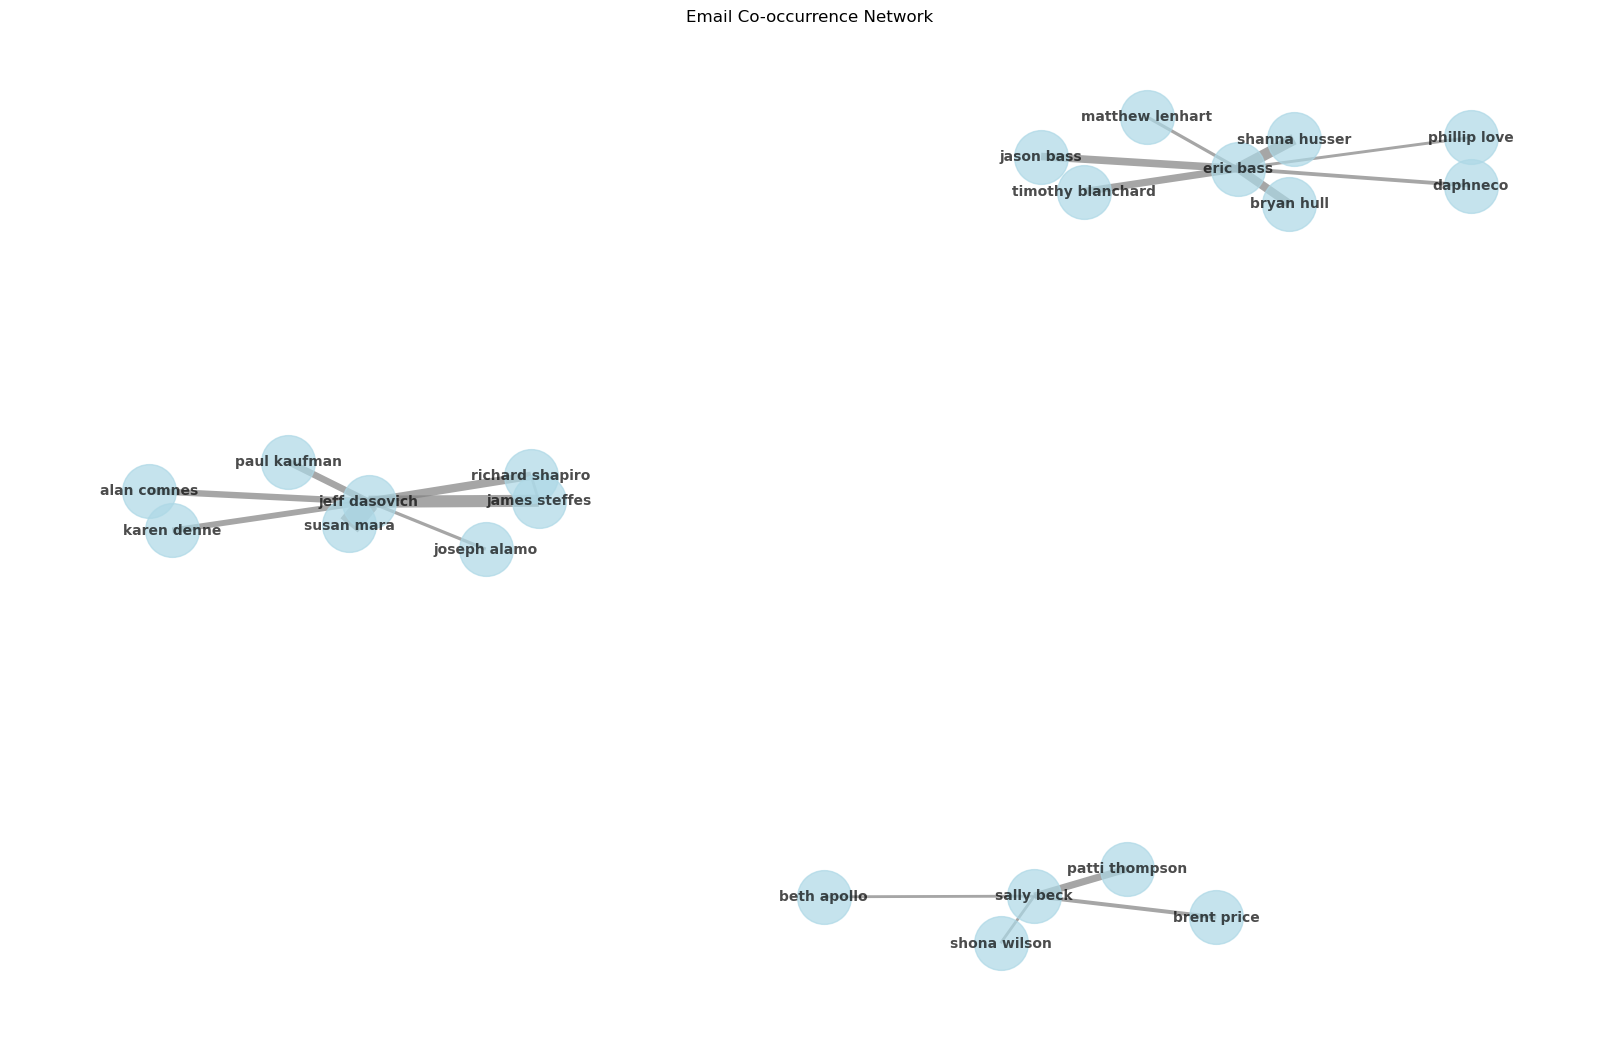

In [41]:
# Visualise Co-occurance Network in a Graph

def filter_edges(graph, min_weight=1000):
    filtered_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        if data["weight"] >= min_weight:
            filtered_graph.add_edge(u, v, weight=data["weight"])
    return filtered_graph

# Visualize the co-occurrence network with improved edge thickness
def visualize_cooccurrence_network(graph):
    plt.figure(figsize=(16, 10))

    # Node positions (spring layout for better spacing)
    pos = nx.spring_layout(graph, seed=42, k=0.5)  # Adjust k to control node spacing

    # Extract edge weights and normalize thickness
    edge_weights = np.array([graph[u][v]['weight'] for u, v in graph.edges()])
    min_width, max_width = 2.0, 16.0  # Define min and max edge thickness
    norm_weights = min_width + (max_width - min_width) * (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

    # Draw the network with adjusted edge thickness
    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='lightblue',
            font_size=10, font_weight='bold', edge_color='gray', width=norm_weights, alpha=0.7)

    # Display the graph
    plt.title("Email Co-occurrence Network")
    plt.show()

# Filter and visualize with adjusted edge thickness
cooccurrence_network_filtered = filter_edges(cooccurrence_network, min_weight=300) # Filter edges with a weight less than 300 have issues
visualize_cooccurrence_network(cooccurrence_network_filtered)

## Work In Progress

### Apply NER on To & From Columns (Not reccomended)

In [ ]:
# #  Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# def extract_name_from_email(email):
#     name_part = email.split('@')[0]  # Get text before @
#     name_cleaned = re.sub(r'[\W\d_]', ' ', name_part)  # Replace non-alphabet characters with spaces
#     name_cleaned = " ".join(name_cleaned.split())  # Remove extra spaces
#     return name_cleaned.title()  # Convert to title case (e.g., "John Lavorato")

# def extract_named_entities_spacy(texts, batch_size=500):
#     # Convert all emails to readable names
#     cleaned_texts = [", ".join([extract_name_from_email(email) for email in text.split(",")]) for text in texts]

#     # Run spaCy NER on extracted names
#     docs = nlp.pipe(cleaned_texts, batch_size=batch_size, disable=["parser", "tagger"])

#     # Extract PERSON entities
#     entity_lists = [[ent.text for ent in doc.ents if ent.label_ == "PERSON"] for doc in docs]

#     return entity_lists

In [ ]:
## Apply the function with batch processing, takes approx 10 mins
## Uncomment below code if you want to run NER for To and From columns
# df['named_entities_to'] = extract_named_entities_spacy(df['To'], batch_size=500) 
# df['named_entities_from'] = extract_named_entities_spacy(df['From'], batch_size=500) 

## df.info()
## df.head(20)


# # Count the number of rows where names were identified
# count_non_empty_to = df[df['named_entities_to'].apply(lambda x: len(x) > 0)].shape[0]
# count_non_empty_from = df[df['named_entities_from'].apply(lambda x: len(x) > 0)].shape[0]

# print(f"Total number of rows: {df.shape[0]}")

# print(f"Number of rows where names_to were identified: {count_non_empty_to}")
# print(f"Percentage of rows where names_to were identified: {count_non_empty_to / df.shape[0] * 100:.2f}%")

# print(f"Number of rows where names_from were identified: {count_non_empty_from}")
# print(f"Percentage of rows where names_from were identified: {count_non_empty_from / df.shape[0] * 100:.2f}%")

### Relationship Extraction (in progress)

In [ ]:
# # Create a communication network dictionary
# communication_network = defaultdict(set)

# for index, row in df.iterrows():
#     sender = row['From']
#     receiver = row['To']
#     entities = row['named_entities']
    
#     # Establish relationships
#     for entity in entities:
#         communication_network[sender].add(entity)
#         communication_network[receiver].add(entity)

# # Convert dictionary to a list of sender-recipient pairs
# edges = []
# for sender, recipients in communication_network.items():
#     for recipient in recipients:
#         edges.append((sender, recipient))

### Social Network Analysis (in progress)

In [ ]:
# # Create a graph
# G = nx.Graph()
# G.add_edges_from(edges)

# # Compute centrality measures
# degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)

# # Print top 5 central figures in the network
# print("Top 5 by Degree Centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# print("Top 5 by Betweenness Centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
# print("Top 5 by Closeness Centrality:", sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

In [ ]:
# plt.figure(figsize=(12, 8))
# nx.draw(G, with_labels=True, node_size=50, font_size=7, edge_color="gray")
# plt.title("Enron Employee Communication Network")
# plt.show()